# CNN + GRU Model

## Import libraries

In [1]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from common_utils import get_dataloader, set_and_get_seed

# Set seed
SEED = set_and_get_seed()

EPOCHS = 30

In [2]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

## Dataset

In [3]:
train_df = pd.read_csv('Heartbeat_Dataset/mitbih_train.csv', header=None)
test_df = pd.read_csv('Heartbeat_Dataset/mitbih_test.csv', header=None)

In [4]:
def get_train_test(train_df, test_df):
    # Separate features and labels
    X_train = train_df.iloc[:, :-1].values  # Exclude label
    y_train = train_df.iloc[:, -1].values   # Labels

    X_test = test_df.iloc[:, :-1].values
    y_test = test_df.iloc[:, -1].values

    return X_train, y_train, X_test, y_test

In [5]:
X_train, y_train, X_test, y_test = get_train_test(train_df, test_df)

# Split the training data to obtain new train and validation sets
# Stratifying the split so both train and validation sets have same class distribution
X_train_new, X_val, y_train_new, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train)

# We add an additional dimension to make it suitable for 1D CNN.
X_train = np.expand_dims(X_train, axis=1)  # Change axis from 2 to 1
X_val = np.expand_dims(X_val, axis=1)    # Change axis from 2 to 1

# Get dataloaders
train_loader = get_dataloader(X_train, y_train, True)
val_loader = get_dataloader(X_val, y_val, False)

## Models

We have two models, the difference lies in having a final dropout layer after the convolution layers. We wanted to test if having a dropout layer will increase the accuracy of the model.

In [6]:
class CNN_GRU(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_GRU, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3),
            nn.BatchNorm1d(num_features=64),
            nn.MaxPool1d(kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3),
            nn.BatchNorm1d(num_features=128),
            nn.MaxPool1d(kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3),
            nn.BatchNorm1d(num_features=256),
            nn.MaxPool1d(kernel_size=2),
            nn.ReLU(),
        )

        self.gru = nn.GRU(input_size=256, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.permute(x, (0, 2, 1))

        x, hidden_state = self.gru(x)
        x = x[:, -1, :]

        x = self.fc(x)
        
        return x

In [7]:
class CNN_GRU_Dropout(nn.Module):
    def __init__(self, num_classes=5):
        super(CNN_GRU_Dropout, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3),
            nn.BatchNorm1d(num_features=64),
            nn.MaxPool1d(kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=3),
            nn.BatchNorm1d(num_features=128),
            nn.MaxPool1d(kernel_size=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3),
            nn.BatchNorm1d(num_features=256),
            nn.MaxPool1d(kernel_size=2),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.gru = nn.GRU(input_size=256, hidden_size=64, batch_first=True)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        x = self.conv_layers(x)
        x = torch.permute(x, (0, 2, 1))

        x, hidden_state = self.gru(x)
        x = x[:, -1, :]

        x = self.fc(x)
        
        return x

## Experiments

### Train and evaluation functions

In [8]:
# Train loop
def train(model, optimizer, train_loader, device, criterion=nn.CrossEntropyLoss()):
    model.train()

    train_correct = 0
    train_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)  # Move data to device
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch.long())
        
        # Backward pass and optimization
        optimizer.zero_grad()  # Clear gradients
        loss.backward()        # Backpropagation
        optimizer.step()       # Update weights

        # Get predictions
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == y_batch).sum().item()
        
        train_loss += loss.item() * X_batch.size(0)  # Accumulate loss

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_accuracy = train_correct / len(train_loader.dataset)

    return train_loss, train_accuracy

In [9]:
# Validation/Test loop
def evaluate(model, scheduler, val_loader, device, criterion=nn.CrossEntropyLoss()):
    model.eval()

    val_loss = 0.0
    val_acc = 0.0
    correct = 0

    with torch.no_grad():  # No need to calculate gradients for validation/testing
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.long())
            val_loss += loss.item() * X_batch.size(0)
            
            # Get predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
        
        # Calculate average validation loss and accuracy
        val_loss /= len(val_loader.dataset)
        val_acc = correct / len(val_loader.dataset)

        scheduler.step()
        
    return val_loss, val_acc 

In [10]:
def train_val_loop(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS):

    early_stopper = EarlyStopper(patience=10)

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, optimizer, train_loader, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        val_loss, val_acc = evaluate(model, scheduler, val_loader, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {train_loss:.4f}, '
            f'Train Accuracy: {train_acc * 100:.2f}%, '
            f'Validation Loss: {val_loss:.4f}, '
            f'Validation Accuracy: {val_acc * 100:.2f}%, '
            f'Learning rate: {scheduler.get_last_lr()}')
        
        if early_stopper.early_stop(val_loss):
            print(f'STOPPED AT EPOCH {epoch}')
            break
        
    return train_losses, train_accuracies, val_losses, val_accuracies

### Model without dropout

In [11]:
# Instantiate model
model = CNN_GRU()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Train
train_losses, train_accuracies, val_losses, val_accuracies = train_val_loop(model, optimizer, scheduler, train_loader, val_loader)

Epoch [1/30], Train Loss: 0.1838, Train Accuracy: 94.93%, Validation Loss: 0.1478, Validation Accuracy: 95.34%, Learning rate: [0.0009972609476841367]
Epoch [2/30], Train Loss: 0.1039, Train Accuracy: 97.13%, Validation Loss: 0.0915, Validation Accuracy: 97.31%, Learning rate: [0.0009890738003669028]
Epoch [3/30], Train Loss: 0.0829, Train Accuracy: 97.70%, Validation Loss: 0.0632, Validation Accuracy: 98.23%, Learning rate: [0.0009755282581475768]
Epoch [4/30], Train Loss: 0.0702, Train Accuracy: 98.04%, Validation Loss: 0.0591, Validation Accuracy: 98.43%, Learning rate: [0.0009567727288213003]
Epoch [5/30], Train Loss: 0.0623, Train Accuracy: 98.25%, Validation Loss: 0.0532, Validation Accuracy: 98.35%, Learning rate: [0.0009330127018922195]
Epoch [6/30], Train Loss: 0.0532, Train Accuracy: 98.39%, Validation Loss: 0.0417, Validation Accuracy: 98.77%, Learning rate: [0.0009045084971874739]
Epoch [7/30], Train Loss: 0.0474, Train Accuracy: 98.62%, Validation Loss: 0.0406, Validation 

In [12]:
# PATH = './model/CNN_GRU_model_val.pth'
# torch.save(model.state_dict(), PATH)

#### Plot loss and accuracy graph of train and validation

In [13]:
import matplotlib.pyplot as plt

def plot_graphs(train_accuracies, train_losses, val_accuracies, val_losses):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
    ax1.plot(range(1, len(val_losses)+1), val_losses, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.legend(loc='lower right')

    ax2.plot(range(1, len(train_accuracies)+1), train_accuracies, label='Training Accuracy')
    ax2.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend(loc='lower right')

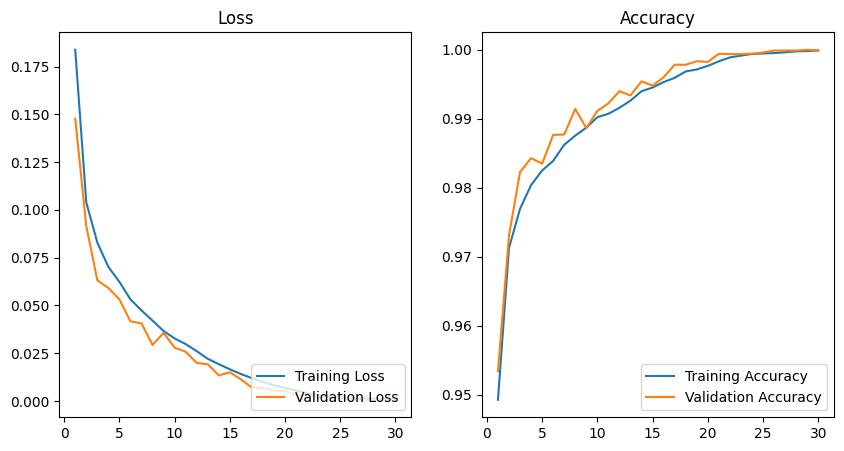

In [15]:
plot_graphs(train_accuracies, train_losses, val_accuracies, val_losses)

### Model with Dropout

In [16]:
# Instantiate model
model = CNN_GRU_Dropout()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

# Train
train_losses, train_accuracies, val_losses, val_accuracies = train_val_loop(model, optimizer, scheduler, train_loader, val_loader)

Epoch [1/30], Train Loss: 0.2001, Train Accuracy: 94.58%, Validation Loss: 0.1172, Validation Accuracy: 96.66%, Learning rate: [0.0009972609476841367]
Epoch [2/30], Train Loss: 0.1125, Train Accuracy: 96.87%, Validation Loss: 0.0901, Validation Accuracy: 97.46%, Learning rate: [0.0009890738003669028]
Epoch [3/30], Train Loss: 0.0915, Train Accuracy: 97.48%, Validation Loss: 0.0729, Validation Accuracy: 97.98%, Learning rate: [0.0009755282581475768]
Epoch [4/30], Train Loss: 0.0783, Train Accuracy: 97.82%, Validation Loss: 0.0691, Validation Accuracy: 98.17%, Learning rate: [0.0009567727288213003]
Epoch [5/30], Train Loss: 0.0710, Train Accuracy: 98.05%, Validation Loss: 0.0634, Validation Accuracy: 98.18%, Learning rate: [0.0009330127018922195]
Epoch [6/30], Train Loss: 0.0623, Train Accuracy: 98.22%, Validation Loss: 0.0492, Validation Accuracy: 98.53%, Learning rate: [0.0009045084971874739]
Epoch [7/30], Train Loss: 0.0562, Train Accuracy: 98.38%, Validation Loss: 0.0419, Validation 

#### Plot loss and accuracy graph of train and validation

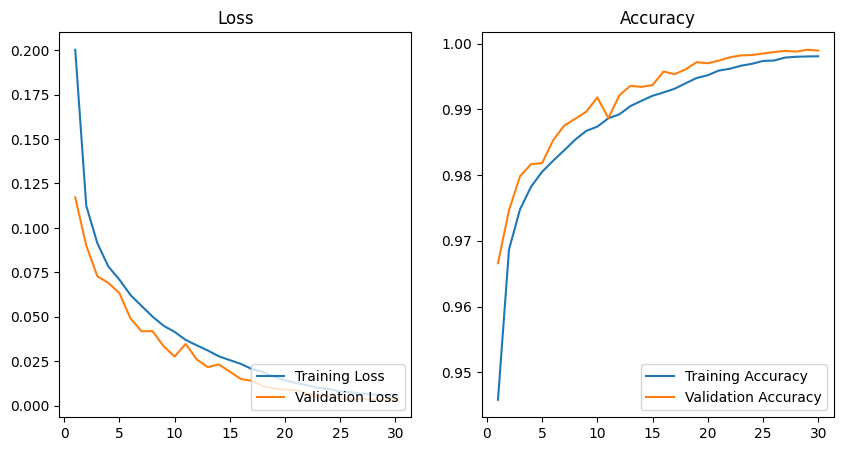

In [18]:
plot_graphs(train_accuracies, train_losses, val_accuracies, val_losses)

The validation results are very similar and the model without dropout layer performs slightly better with lower validation loss and higher classification accuracy. As such, we will use the model without dropout in the later portion and for future experiments.

## Test

In [19]:
def train_test_loop(model, optimizer, scheduler, train_loader, test_loader, num_epochs=EPOCHS):

    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []

    for epoch in range(num_epochs):
        train_loss, train_acc = train(model, optimizer, train_loader, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        test_loss, test_acc = evaluate(model, scheduler, test_loader, device)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)

        # Print epoch results
        print(f'Epoch [{epoch+1}/{num_epochs}], '
            f'Train Loss: {train_loss:.4f}, '
            f'Train Accuracy: {train_acc * 100:.2f}%, '
            f'Test Loss: {test_loss:.4f}, '
            f'Test Accuracy: {test_acc * 100:.2f}%')
        
    return train_losses, train_accuracies, test_losses, test_accuracies

In [20]:
# Instantiate model
model = CNN_GRU()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [21]:
X_train, y_train, X_test, y_test = get_train_test(train_df, test_df)

# We add an additional dimension to make it suitable for 1D CNN.
X_train = np.expand_dims(X_train, axis=1)  # Change axis from 2 to 1
X_test = np.expand_dims(X_test, axis=1)    # Change axis from 2 to 1

# Get dataloaders
train_loader = get_dataloader(X_train, y_train, True)
test_loader = get_dataloader(X_test, y_test, False)

In [22]:
train_losses, train_accuracies, test_losses, test_accuracies = train_test_loop(model, optimizer, scheduler, train_loader, test_loader)

Epoch [1/30], Train Loss: 0.1889, Train Accuracy: 94.85%, Test Loss: 0.1255, Test Accuracy: 96.64%
Epoch [2/30], Train Loss: 0.1051, Train Accuracy: 97.14%, Test Loss: 0.1160, Test Accuracy: 96.62%
Epoch [3/30], Train Loss: 0.0833, Train Accuracy: 97.66%, Test Loss: 0.0814, Test Accuracy: 97.78%
Epoch [4/30], Train Loss: 0.0709, Train Accuracy: 97.99%, Test Loss: 0.0745, Test Accuracy: 97.96%
Epoch [5/30], Train Loss: 0.0609, Train Accuracy: 98.23%, Test Loss: 0.0712, Test Accuracy: 98.06%
Epoch [6/30], Train Loss: 0.0548, Train Accuracy: 98.41%, Test Loss: 0.0628, Test Accuracy: 98.25%
Epoch [7/30], Train Loss: 0.0472, Train Accuracy: 98.58%, Test Loss: 0.0611, Test Accuracy: 98.29%
Epoch [8/30], Train Loss: 0.0423, Train Accuracy: 98.76%, Test Loss: 0.0580, Test Accuracy: 98.41%
Epoch [9/30], Train Loss: 0.0384, Train Accuracy: 98.83%, Test Loss: 0.0611, Test Accuracy: 98.36%
Epoch [10/30], Train Loss: 0.0330, Train Accuracy: 99.00%, Test Loss: 0.0560, Test Accuracy: 98.38%
Epoch [11

In [23]:
PATH = './model/CNN_GRU_model.pth'
torch.save(model.state_dict(), PATH)

In [24]:
y_pred, y_true = [], []
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

with torch.no_grad():  # No need to calculate gradients for validation/testing
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)

        _, predictions = torch.max(outputs, 1)

        y_pred.append(predictions.float().detach().cpu())
        y_true.append(y_batch.cpu())

preds = torch.cat(y_pred).numpy()
truths = torch.cat(y_true).numpy()

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

report = classification_report(truths, preds, labels=[0.0, 1.0, 2.0, 3.0, 4.0], target_names=['N', 'S', 'V', 'F', 'Q'], output_dict=True)
conf_matrix = confusion_matrix(truths, preds, labels=[0.0, 1.0, 2.0, 3.0, 4.0])

In [26]:
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
N,0.991747,0.994867,0.993304,18118.000000
S,0.888454,0.816547,0.850984,556.000000
V,0.966667,0.961326,0.963989,1448.000000
F,0.820809,0.876543,0.847761,162.000000
Q,0.995606,0.986318,0.990940,1608.000000
accuracy,0.986616,0.986616,0.986616,0.986616
macro avg,0.932657,0.927120,0.929396,21892.000000
weighted avg,0.986483,0.986616,0.986500,21892.000000


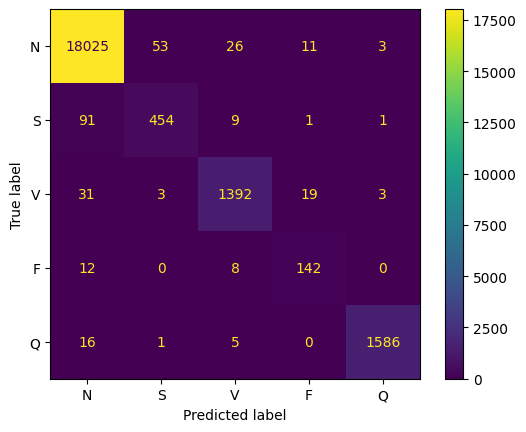

In [27]:
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['N', 'S', 'V', 'F', 'Q'])
disp.plot()

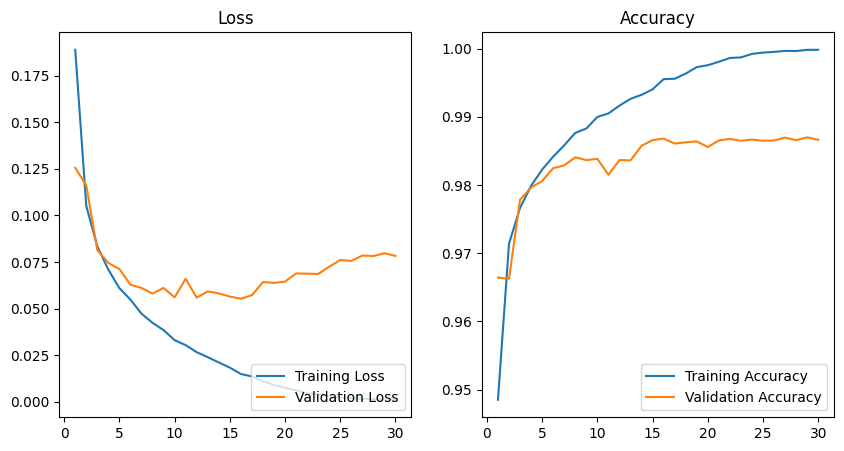

In [28]:
plot_graphs(train_accuracies, train_losses, test_accuracies, test_losses)